# I-JEPA

## Get embeddings
The I-JEPA model is not inferencible the way Meta released it.  I had to reverse engineer it to be able to get embedings out of it.  This code is going to download my Git repository with I-JEPA and save image latents

In [7]:
# Download Git repository 

!gh repo clone git@github.com:ianjwhitehouse/inference-ijepa.git
!wget -P inference-ijepa/logs/vith16.448-bs.2048-ep.300 https://dl.fbaipublicfiles.com/ijepa/IN1K-vit.h.16-448px-300e.pth.tar

fatal: destination path 'inference-ijepa' already exists and is not an empty directory.
failed to run git: exit status 128
--2024-05-05 01:26:09--  https://dl.fbaipublicfiles.com/ijepa/IN1K-vit.h.16-448px-300e.pth.tar
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.39.25, 13.249.39.89, 13.249.39.82, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.39.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10367908521 (9.7G) [application/x-tar]
Saving to: ‘inference-ijepa/logs/vith16.448-bs.2048-ep.300/IN1K-vit.h.16-448px-300e.pth.tar’

IN1K-vit.h.16-448px 100%[===================>]   9.66G   105MB/s    in 1m 40s  

2024-05-05 01:27:49 (98.6 MB/s) - ‘inference-ijepa/logs/vith16.448-bs.2048-ep.300/IN1K-vit.h.16-448px-300e.pth.tar’ saved [10367908521/10367908521]



In [18]:
# Create JEPA config files
import os

cwd = os.getcwd()
img_path = os.path.join(cwd, "images/training_imgs")
logging_path = os.path.join(cwd, "inference-ijepa/logs/vith16.448-bs.2048-ep.300/")

config_file = """data:
  batch_size: 16
  color_jitter_strength: 0.0
  crop_scale:
  - 0.3
  - 1.0
  crop_size: 448
  image_folder: .
  num_workers: 10
  pin_mem: true
  root_path: %s
  use_color_distortion: false
  use_gaussian_blur: false
  use_horizontal_flip: false
logging:
  folder: %s
  write_tag: jepa
mask:
  allow_overlap: false
  aspect_ratio:
  - 0.75
  - 1.5
  enc_mask_scale:
  - 0.85
  - 1.0
  min_keep: 10
  num_enc_masks: 1
  num_pred_masks: 4
  patch_size: 16
  pred_mask_scale:
  - 0.15
  - 0.2
meta:
  copy_data: false
  load_checkpoint: true
  model_name: vit_huge
  pred_depth: 12
  pred_emb_dim: 384
  read_checkpoint: IN1K-vit.h.16-448px-300e.pth.tar
  use_bfloat16: true
optimization:
  ema:
  - 0.996
  - 1.0
  epochs: 300
  final_lr: 1.0e-06
  final_weight_decay: 0.4
  ipe_scale: 1.0
  lr: 0.001
  start_lr: 0.0002
  warmup: 40
  weight_decay: 0.04"""

with open("jepa_train_config.yaml", "w") as f:
    f.write(config_file % (img_path, logging_path))

img_path = os.path.join(cwd, "images/example_imgs")
with open("jepa_test_config.yaml", "w") as f:
    f.write(config_file % (img_path, logging_path))

In [ ]:
# Run I-JEPA

!python inference-ijepa/main-inference.py --fname=jepa_train_config.yaml
!mv images/training_imgs/jepa_encodings.pkl jepa_encodings_train.pkl
!python inference-ijepa/main-inference.py --fname=jepa_test_config.yaml
!mv images/example_imgs/jepa_encodings.pkl jepa_encodings_test.pkl

## Visualize model embeddings

In [1]:
# Load images
from pickle import load
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeds = load(open("jepa_encodings_train.pkl", "rb"))

# Break into categories
clothing_embed = {k:v for k, v in embeds.items() if k.endswith("c.png")}
clothing_labels = [k.split("-")[0].split("_") for k in clothing_embed.keys()]
clothing_labels = [[lab[0], lab[1], lab[2][:-1]] if lab[2].endswith("s") else lab for lab in clothing_labels]
clothing_embed = np.array(list(clothing_embed.values()))
clothing_pca = PCA(n_components=2).fit(clothing_embed)
print(clothing_pca.explained_variance_ratio_, sum(clothing_pca.explained_variance_ratio_))
clothing_pca = clothing_pca.transform(clothing_embed)
clothing_tsne = TSNE().fit_transform(clothing_embed)

full_body_embed = {k:v for k, v in embeds.items() if k.endswith("fb.png")}
full_body_labels = [k.split("-")[0].split("_") for k in full_body_embed.keys()]
full_body_labels = [[lab[0], lab[1], lab[2][:-1]] if lab[2].endswith("s") else lab for lab in full_body_labels]
full_body_embed = np.array(list(full_body_embed.values()))
full_body_pca = PCA(n_components=2).fit(full_body_embed)
print(full_body_pca.explained_variance_ratio_, sum(full_body_pca.explained_variance_ratio_))
full_body_pca = full_body_pca.transform(full_body_embed)
full_body_tsne = TSNE().fit_transform(full_body_embed)

[0.33181998 0.13583803] 0.4676580036554549
[0.25311901 0.17600127] 0.4291202792909494


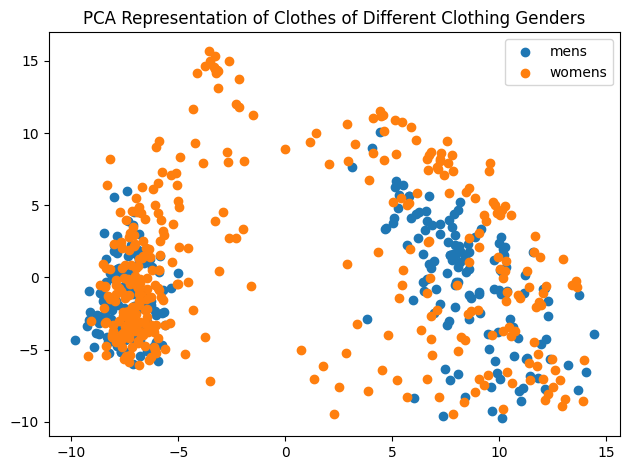

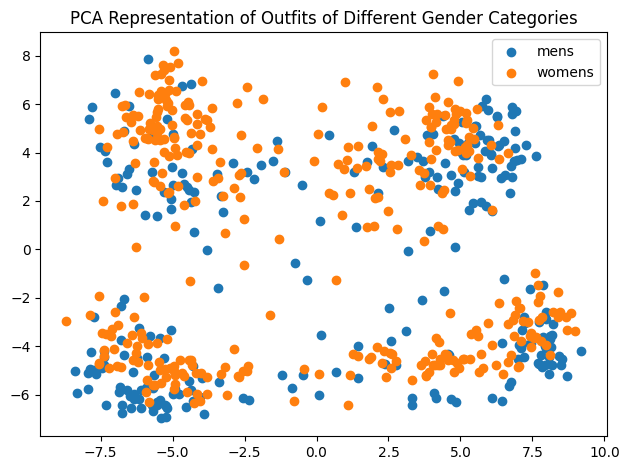

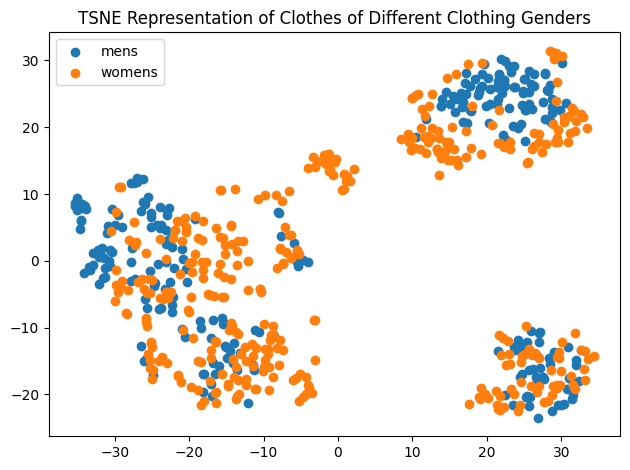

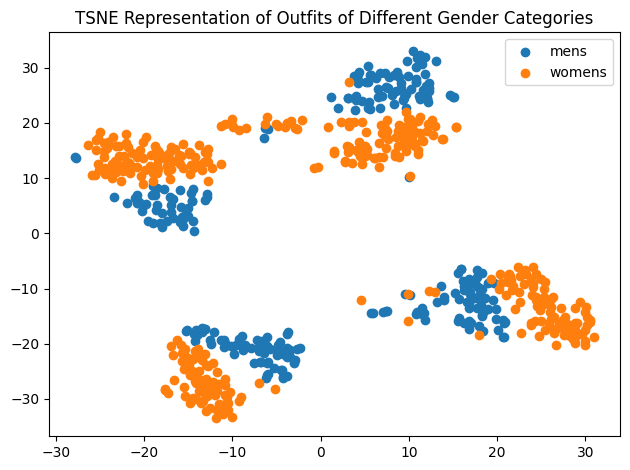

In [2]:
# Plot gendered items
import matplotlib.pyplot as plt

for gender in ["mens", "womens"]:
    plt.scatter(
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 0],
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("PCA Representation of Clothes of Different Clothing Genders")
plt.tight_layout()
plt.legend()
plt.show()

for gender in ["mens", "womens"]:
    plt.scatter(
        full_body_pca[[i for i in range(len(clothing_pca)) if full_body_labels[i][1] == gender]][:, 0],
        full_body_pca[[i for i in range(len(clothing_pca)) if full_body_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("PCA Representation of Outfits of Different Gender Categories")
plt.tight_layout()
plt.legend()
plt.show()

for gender in ["mens", "womens"]:
    plt.scatter(
        clothing_tsne[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 0],
        clothing_tsne[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("TSNE Representation of Clothes of Different Clothing Genders")
plt.tight_layout()
plt.legend()
plt.show()

for gender in ["mens", "womens"]:
    plt.scatter(
        full_body_tsne[[i for i in range(len(clothing_pca)) if full_body_labels[i][1] == gender]][:, 0],
        full_body_tsne[[i for i in range(len(clothing_pca)) if full_body_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("TSNE Representation of Outfits of Different Gender Categories")
plt.tight_layout()
plt.legend()
plt.show()

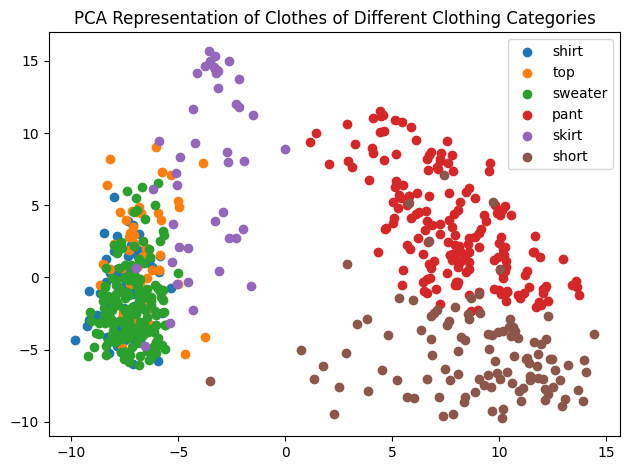

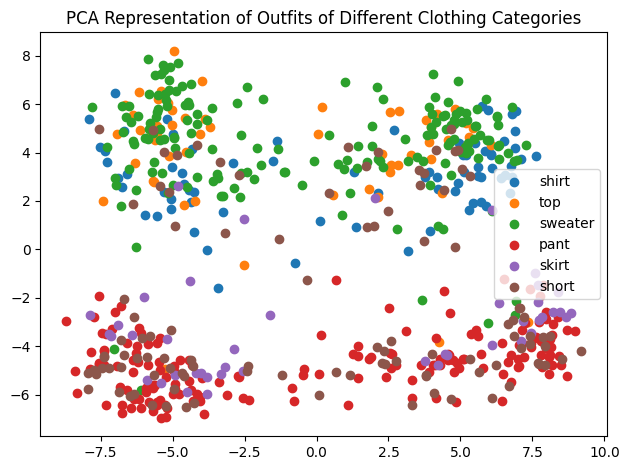

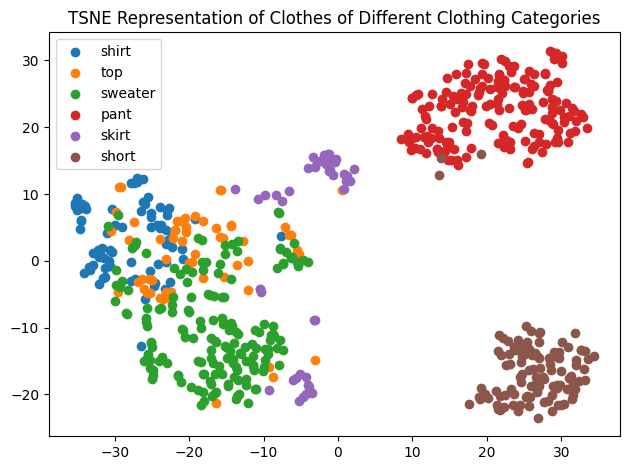

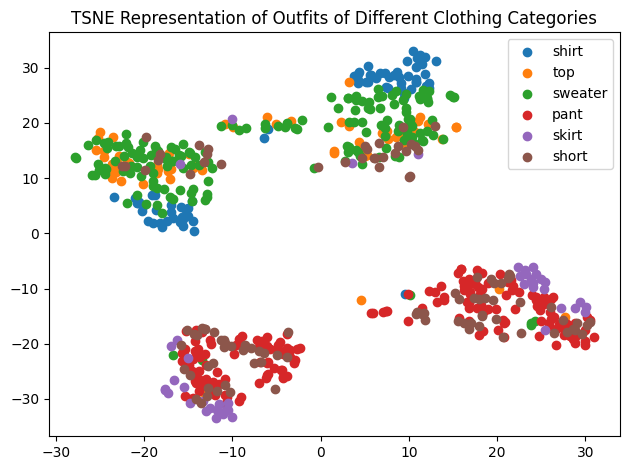

In [3]:
# Plot types of items
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:
    plt.scatter(
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 0],
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("PCA Representation of Clothes of Different Clothing Categories")
plt.tight_layout()
plt.legend()
plt.show()

for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:
    plt.scatter(
        full_body_pca[[i for i in range(len(clothing_pca)) if full_body_labels[i][2] == item]][:, 0],
        full_body_pca[[i for i in range(len(clothing_pca)) if full_body_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("PCA Representation of Outfits of Different Clothing Categories")
plt.tight_layout()
plt.legend()
plt.show()

for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:
    plt.scatter(
        clothing_tsne[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 0],
        clothing_tsne[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("TSNE Representation of Clothes of Different Clothing Categories")
plt.tight_layout()
plt.legend()
plt.show()

for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:
    plt.scatter(
        full_body_tsne[[i for i in range(len(clothing_pca)) if full_body_labels[i][2] == item]][:, 0],
        full_body_tsne[[i for i in range(len(clothing_pca)) if full_body_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("TSNE Representation of Outfits of Different Clothing Categories")
plt.tight_layout()
plt.legend()
plt.show()

## Run test images